#                                   visualisation

1)  Import packages

Dans cette partie nous allons importer toutes les packages utiles pour notre visualisation.

Certains packages n'ont pas été vus en cours donc nécéssite une installation

Ainsi faudra installer le module :

pip install plotly_express==0.4.0
    
    

In [43]:
import json
import pandas as pd
import os
import glob
import re
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

import folium
from folium import plugins

2) Importaion de données 

Nous importons les données  via le site:
    
http://data.montpellier3m.fr/dataset/comptages-velo-et-pieton-issus-des-eco-compteurs/resource/75f5e367-99fb-482f-ba5c

In [7]:
#Nous utilions *.json car nous vons téléchargé les données dans le me repertoire que nous traivaillons
list_files = glob.glob("*.json")
list_files

['MMM_EcoCompt_X2H19070220_Archive2020.json',
 'MMM_EcoCompt_X2H20042632_Archive2020.json',
 'MMM_EcoCompt_X2H20042633_Archive2020.json',
 'MMM_EcoCompt_X2H20042634_Archive2020.json',
 'MMM_EcoCompt_X2H20042635_Archive2020.json',
 'MMM_EcoCompt_X2H20063161_Archive2020.json',
 'MMM_EcoCompt_X2H20063162_Archive2020.json',
 'MMM_EcoCompt_X2H20063163_Archive2020.json',
 'MMM_EcoCompt_X2H20063164_Archive2020.json',
 'MMM_EcoCompt_XTH19101158_Archive2020.json']

Par la sortie code nous avons dix fichiers en json. Ainsi nous allons les regrouper ensemble



Dataframe des données

In [8]:
## Lecture données
data = pd.concat([pd.read_json(i, lines=True) for i in list_files])
data.head()

,intensity,laneId,dateObserved,location,id,type,vehicleType,reversedLane
0,542,121403593,2020-01-01T00:00:00/2020-01-02T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001010000,TrafficFlowObserved,bicycle,False
1,598,121403593,2020-01-02T00:00:00/2020-01-03T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001020000,TrafficFlowObserved,bicycle,False
2,731,121403593,2020-01-03T00:00:00/2020-01-04T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001030000,TrafficFlowObserved,bicycle,False
3,793,121403593,2020-01-04T00:00:00/2020-01-05T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001040000,TrafficFlowObserved,bicycle,False
4,943,121403593,2020-01-05T00:00:00/2020-01-06T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001050000,TrafficFlowObserved,bicycle,False


In [9]:
#Donne les informations du Dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152 entries, 0 to 294
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   intensity     2152 non-null   int64 
 1   laneId        2152 non-null   int64 
 2   dateObserved  2152 non-null   object
 3   location      2152 non-null   object
 4   id            2152 non-null   object
 5   type          2152 non-null   object
 6   vehicleType   2152 non-null   object
 7   reversedLane  2152 non-null   bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 136.6+ KB


Nous allons créer les varaibles: date, latitude et longitude

In [10]:
# Fonction pour récuperer le ieme nombre d'une chaine de caractere
def get_number(text,i):
  num = re.findall(r'\d*\.\d*',text)
  return num[i]

data['date'] = pd.to_datetime(data['dateObserved'].str[:10], format='%Y-%m-%d')
data['longitude']=data['location'].astype('str').apply(lambda x: get_number(x,0)).astype('float')
data['latitude']=data['location'].astype('str').apply(lambda x: get_number(x,1)).astype('float')

data[['date', 'latitude', 'longitude']].head()

,date,latitude,longitude
0,2020-01-01,43.609699,3.89694
1,2020-01-02,43.609699,3.89694
2,2020-01-03,43.609699,3.89694
3,2020-01-04,43.609699,3.89694
4,2020-01-05,43.609699,3.89694


Nous allons faire juste une petite répresenetation graphique du nombre de vélo par jour grace à leur id et leur date

<AxesSubplot:xlabel='date'>

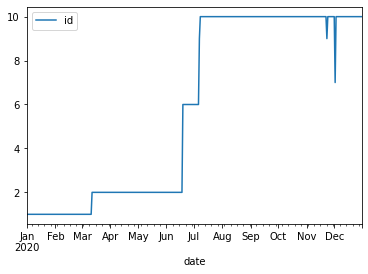

In [11]:
## NB Velos par jour : 
data_jour = data[['date', 'id']].groupby("date").agg({'id' : 'count'})
data_jour.plot()

Cette graphe nous montre juste durant quelle période qu'il  y'aurait plus de circullation de vélo sur montpellier.

Cela semble néttement justifiable ccar à partir du mois de juin l'Eté débute.

Et vers le mois de décembre il y'a un chutte car on est en péride Hiver.


Nous allons continuer pour faire mieux avec une répréation du nombre de vélo par adrésse.

Ici nous allons mettre les données dans un fichier excel pour les réutliser.

In [13]:
data.to_excel('all_data.xlsx')

In [28]:
df = pd.read_excel('all_data.xlsx')

# Mettre les variables en float 

df['Latitude'] = df['latitude'].astype(float)
df['Longitude'] = df['longitude'].astype(float)
map_df = df[['Latitude', 'Longitude', 'date', 'id']]

list_dates = map_df['date'].astype('str').unique().tolist()
print(len(list_dates))
list_dates[-3:]

366


['2020-12-29', '2020-12-30', '2020-12-31']

3) Nous allons faire une catre qui va répréseneter le nombre de velo par secteur(Adresse).

In [33]:
from matplotlib import dates
import datetime

## Fonction pour afficher le nombre de velos par site pour une date données

## date doit etre une liste
def plot_nb_velo_date(data , date):
    print("Date entre ", min(date) ," et ", max(date))
    df_count = data[data['date'].astype('str').isin(date) ].groupby(['Latitude', 'Longitude']).agg({'id': 'count'}).reset_index()
  
  ## Preparer carte sur Montpellier 
    map_montpellier = folium.Map(location=[43.610769, 3.876716],
                    zoom_start = 14)
  
  ## Rajouter points avec les vélos + nb velos
    for l,L,nb in zip(df_count['Latitude'],df_count['Longitude'], df_count['id'] ) :
        folium.Marker([float(l), float(L)], 
              popup= str(nb),
              icon=folium.Icon(color='blue',icon='bicycle', prefix='fa')
             ).add_to(map_montpellier)
        folium.Marker(
        [float(l) , float(L) ],
        icon=folium.DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 15pt">%s</div>' % nb,
        )
        ).add_to(map_montpellier)

    return {"map" : map_montpellier}




In [ ]:
Nous regroupons variables, Latitude, Longitude date en fonction de leuu id

In [16]:
map_df.groupby(['Latitude', 'Longitude', 'date']).agg({'id': 'count'}).reset_index().sort_values('id', ascending =False) 

,Latitude,Longitude,date,id
1974,43.626698,3.895629,2020-12-31,2
1842,43.626698,3.895629,2020-08-21,2
1862,43.626698,3.895629,2020-09-10,2
1861,43.626698,3.895629,2020-09-09,2
1860,43.626698,3.895629,2020-09-08,2
...,...,...,...,...
654,43.609699,3.896940,2020-03-08,1
653,43.609699,3.896940,2020-03-07,1
652,43.609699,3.896940,2020-03-06,1
651,43.609699,3.896940,2020-03-05,1


In [40]:
## Afficher graphique avec les 300 premieres dates
plot_nb_velo_date(map_df, list_dates[:200])['map']

Date entre  2020-01-01  et  2020-07-18


Cette carte répésesnte le nombre par date sur montepplier entre Janvier et Décembre 2020.

Nouns avons réprenté les 300 premiers dates.


Qu'on peut ainsi modifier  pour voir  le nombre de vélos qui passe à  des adrésses différents.
